In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

# Generate random data and related columns
np.random.seed(0)
x = pd.DataFrame(np.random.normal(size=(1000, 2)), columns=['A', 'B'])
x['C'] = x['A'] ** 2 - np.tanh(x['B'])
x['D'] = 0.5 * np.exp(x['B']) - x['A']

# Store the mean and covariance values for the inputs
mean_x = x.mean()
covariance_x = x.cov()

# Split data into train and test
x_train, x_test = train_test_split(x, test_size=0.25, random_state=0)

# Check shape of train data
x_train.shape

(750, 4)

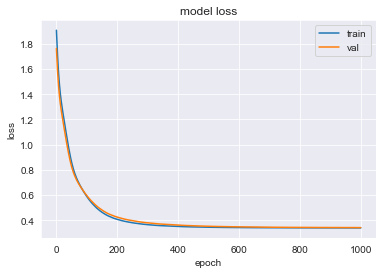

In [2]:
from keras import layers
from keras.models import Sequential
from keras.losses import MeanSquaredError
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt

# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# Our model is an autoencoder with non-linear encoder and linear decoder
non_linear_autoencoder = Sequential(
    [
        layers.Input(4),
        layers.Dense(2, activation='sigmoid', name='hidden'),
        layers.Dense(4, activation=None, use_bias=False, name='output')
    ]
)

# Compile the model with the optimizer and loss
non_linear_autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

# Train the autoencoder for N epochs
train_history = non_linear_autoencoder.fit(x_train, x_train,
                                           epochs=1000,
                                           batch_size=32,
                                           shuffle=True,
                                           validation_data=(x_test, x_test),
                                           verbose=0)

# We now define the linear encoder that will be used to obtain the latent space
non_linear_encoder = Model(
    inputs=non_linear_autoencoder.inputs,
    outputs=non_linear_autoencoder.get_layer(name='hidden').output,
)

# Plot the test and train loss over time
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc=1)
plt.show()

In [3]:
# Obtain the hidden latent representation
h = non_linear_encoder.predict(x)

# Obtain the reconstruction
r = non_linear_autoencoder.predict(x)

# Get the weight matrix
A = non_linear_autoencoder.get_weights()[2].T

# Show that r = Ah
difference = (r - (A @ h.T).T)
difference[:5]

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 7.4505806e-09,  0.0000000e+00,  0.0000000e+00,  1.4901161e-08],
       [ 0.0000000e+00, -1.4901161e-08,  0.0000000e+00, -5.9604645e-08]],
      dtype=float32)

In [4]:
def estimate_x_mean(latent, decoder_matrix):
    """
    Estimate the mean of x from h and the decoder matrix.
    """
    mean_h = np.mean(latent, axis=0)
    return (decoder_matrix @ mean_h.T).T

# Calculate the mean of r empirically
mean_r = np.mean(r, axis=0)

# Use our formula to calculate the mean of r
estimate_x_mean(h, A)

array([-0.27785885, -0.01942696,  1.1092345 ,  0.8298072 ], dtype=float32)

In [5]:
import itertools

def estimate_x_covariance(cov_h, decoder_matrix):
    """
    Estimate the covariance matrix of x from h and the decoder matrix.
    """
    dimension = decoder_matrix.shape[0]
    indexes = list(range(dimension))
    covariance_matrix = np.zeros((dimension, dimension))
    for i, j in itertools.product(indexes, indexes):
        covariance_matrix[i, j] = estimate_x_covariance_ij(i, j, cov_h, decoder_matrix)
    return covariance_matrix

def estimate_x_covariance_ij(i, j, cov_h, decoder_matrix):
    """
    Estimate the covariance between x_i and x_j.
    """
    indexes = list(range(cov_h.shape[0]))
    summation = [decoder_matrix[i, k] * decoder_matrix[j, l] * cov_h[k, l]
                 for k, l in itertools.product(indexes, indexes)]
    return np.sum(summation)

# Estimate the covariance matrix of x
estimate_x_covariance(np.cov(h.T), A)

array([[ 0.30006022, -0.33558023,  0.27304715, -0.72497824],
       [-0.33558023,  0.45327657, -0.62702495,  0.77337574],
       [ 0.27304715, -0.62702495,  1.57538805, -0.50533209],
       [-0.72497824,  0.77337574, -0.50533209,  1.76958766]])